# 12. Задача о кратчайших путях: алг. Дейкстры на 2-куче и на  фибоначчиевой куче

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import math
import time
import random

## Graph class

In [2]:
class Graph:
    def __init__(self):
        self.nodes = set()
        self.edges = {}

    def add_node(self, value):
        self.nodes.add(value)
        self.edges[value] = []

    def add_edge(self, from_node, to_node, weight):
        self.edges[from_node].append((to_node, weight))
        self.edges[to_node].append((from_node, weight))

def generate_random_graph(num_nodes):
    g = Graph()
    for i in range(num_nodes):
        g.add_node(str(i))
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            weight = random.randint(1, 100)
            g.add_edge(str(i), str(j), weight)

    return g

## 2 heap

In [3]:
class MaxHeap:
    class Node:
        def __init__(self, name, weight, index = 0):
            self.index = index
            self.name = name
            self.weight = weight
            
    def __init__(self):
        self.heap = []
        self.list_of_nodes = [None]

    def push(self, value):
        n = self.Node(value[0], value[1], len(self.heap))
        while len(self.list_of_nodes) < int(value[0]) + 1:
            self.list_of_nodes.append(None)
        self.list_of_nodes[int(value[0])] = n
        self.heap.append(n)
        self.emersion(len(self.heap)-1)

    def pop(self):
        if len(self.heap) > 1:
            self._swap(0, len(self.heap) - 1)
            min_value = self.heap.pop()
            self.diving()
        elif len(self.heap) == 1:
            min_value = self.heap.pop()
        else:
            min_value = None
        min_value.index = -1
        return (min_value.name, min_value.weight)
            
    def min_child(self, index):
        if len(self.heap) == index + 1:
            return -1
        min = self.heap[index+1].weight
        if len(self.heap) >= index + 3 and self.heap[index+2].weight < min:
            return index+2
        return index+1
    
    def diving(self):
        j_1 = 0
        j_2 = self.min_child(j_1)
        while j_2 != -1 and self.heap[j_1].weight > self.heap[j_2].weight:
            self._swap(j_1,j_2)
            j_1 = j_2
            j_2 = self.min_child(j_2)
    
    def is_empty(self):
        return not bool(self.heap)

    def _swap(self, i, j):
        self.heap[i], self.heap[j] = self.heap[j], self.heap[i]
        t = self.heap[i].index
        self.heap[i].index = self.heap[j].index
        self.heap[j].index = t
        
    def make_heap(self, weights):
        for w in weights:
            self.push(w)
            
    def emersion(self, index):
        parent_index = 0
        while index > 0:
            parent_index = (index - 1) // 2
            if self.heap[index].weight < self.heap[parent_index].weight:
                self._swap(index, parent_index)
                index = parent_index
            else:
                break
            
    def find(self, node_target):
        for i, node in enumerate(self.heap):
            if node.name == node_target:
                return node.index
        return -1
            
    def decrease_weight(self, index, weight):
        self.heap[index].weight = weight
        self.emersion(index)
    
    def print(self):
        for element in self.heap:
            print(element)

## Dijkstra using 2-heap

In [4]:
def dijkstra2heap(graph, start_node):
    distances = {node: float('infinity') for node in graph.nodes}
    distances[start_node] = 0

    heap = MaxHeap()
    for v in graph.nodes:
        if v != start_node:
            heap.push((v, math.inf))
        else:
            heap.push((v, 0))

    while not heap.is_empty():
        current_node, current_distance = heap.pop()
        for neighbor, weight in graph.edges[current_node]:
            index = heap.list_of_nodes[int(neighbor)].index # heap.find(neighbor)
            if index != -1:
                distance = current_distance + weight
                if distance < heap.heap[index].weight:
                    distances[neighbor] = distance
                    heap.decrease_weight(index, distance)
        
    return distances

## Fibonacci heap

In [5]:
class FibonacciHeap:
    
    class Node:
        def __init__(self, name, weight):
            self.name = name
            self.weight = weight
            self.parent = None
            self.child = None
            self.left = None
            self.right = None
            self.degree = 0
            self.mark = False
            
    root_list, min_node = None, None
    list_of_nodes = [None]
    total_nodes = 0
    
    def merge_with_root_list(self, node):
        if self.root_list is None:
            self.root_list = node
        else:
            node.right = self.root_list.right
            node.left = self.root_list
            self.root_list.right.left = node
            self.root_list.right = node
    
    def insert(self, name, weight = math.inf):
        n = self.Node(name, weight)
        n.left = n
        n.right = n
        self.merge_with_root_list(n)
        if self.min_node is None or n.weight < self.min_node.weight:
            self.min_node = n
        self.total_nodes += 1
        while len(self.list_of_nodes) < int(name) + 1:
            self.list_of_nodes.append(None)
        self.list_of_nodes[int(name)] = n
        return n
    
    def is_empty(self):
        if self.total_nodes == 0:
            return True
        return False
    
    def iterate(self, head):
        node = head 
        stop = head
        flag = False
        while True:
            if node == stop and flag is True:
                break
            elif node == stop:
                flag = True
            yield node
            node = node.right
            
    def remove_from_root_list(self, node):
        if node == self.root_list:
            self.root_list = node.right
        node.left.right = node.right
        node.right.left = node.left
    
    def merge_with_child_list(self, parent, node):
        if parent.child is None:
            parent.child = node
        else:
            node.right = parent.child.right
            node.left = parent.child
            parent.child.right.left = node
            parent.child.right = node
        
    def heap_link(self, y, x):
        self.remove_from_root_list(y)
        y.left = y.right = y
        self.merge_with_child_list(x, y)
        x.degree += 1
        y.parent = x
        y.mark = False
        return x
        
    def consolidate(self):
        A = [None] * int(math.log(self.total_nodes) * 2)
        nodes = [w for w in self.iterate(self.root_list)]
        for x in nodes:
            d = x.degree
            while A[d] != None:
                y = A[d]
                if x.weight > y.weight:
                    x = self.heap_link(x, y)
                else:
                    x = self.heap_link(y, x)
                A[d] = None
                d += 1
            A[d] = x
        for i in range(0, len(A)):
            if A[i] is not None:
                if A[i].weight <= self.min_node.weight:
                    self.min_node = A[i]
    
    def pop(self):
        current_min = self.min_node
        if current_min is not None:
            if current_min.child is not None:
                children = [x for x in self.iterate(current_min.child)]
                for i in range(0, len(children)):
                    self.merge_with_root_list(children[i])
                    children[i].parent = None
            self.remove_from_root_list(current_min)
            if current_min == current_min.right:
                self.min_node = None
                self.root_list = None
            else:
                self.min_node = current_min.right
                self.consolidate()
            self.total_nodes -= 1
        return current_min
    
    def find(self, name, start_node = None):
        if start_node == None:
            start_node = self.root_list
        current_node = start_node
        while current_node:
            if current_node.name == name:
                return current_node
            if current_node.child:
                child_result = self.find(name, current_node.child)
                if child_result:
                    return child_result
            current_node = current_node.right
            if current_node == start_node:
                break
        return None
    
    def swap(self, name1, name2):
        t = self.list_of_nodes[int(name1)]
        self.list_of_nodes[int(name1)] = self.list_of_nodes[int(name2)]
        self.list_of_nodes[int(name2)] = t
        
    def emersion(self, node):
        parent = node.parent
        while parent and node.weight < parent.weight:
            parent_weight = parent.weight
            parent.weight = node.weight
            node.weight = parent_weight
            parent_name = parent.name
            parent.name = node.name
            node.name = parent_name
            self.swap(parent.name, node.name)
            node = parent
            parent = node.parent
        return node
    
    def decrease_weight(self, node, new_weight):
        node.weight = new_weight
        node = self.emersion(node)
        if node.weight < self.min_node.weight:
            self.min_node = node
    

## Dijkstra using Fibonacci heap

In [6]:
def dijkstraFib(graph, start_node):
    distances = {node: float('infinity') for node in graph.nodes}
    distances[start_node] = 0
    heap = FibonacciHeap()
    for v in graph.nodes:
        if v != start_node:
            n = heap.insert(v)
        else:
            n = heap.insert(v,0)
    while not heap.is_empty():
        current_node = heap.pop()
        current_distance = current_node.weight
        for neighbor, weight in graph.edges[current_node.name]:
            neighbor_node = heap.list_of_nodes[int(neighbor)]
            if neighbor_node != None:
                distance = current_distance + weight
                if distance < neighbor_node.weight:
                    distances[neighbor] = distance
                    heap.decrease_weight(neighbor_node, distance)
        
    return distances

## Check

In [7]:
num_nodes = 1000
random_graph = generate_random_graph(num_nodes)
res_2heap = dijkstra2heap(random_graph,'1')
res_fib = dijkstraFib(random_graph,'1')

In [8]:
for element in random_graph.nodes:
    if res_fib[element] != res_2heap[element]:
        print('Error')

In [9]:
def dijkstraN2(graph, start_node):
    distances = {node: float('infinity') for node in graph.nodes}
    distances[start_node] = 0

    while graph.nodes:
        current_node = min(graph.nodes, key=lambda node: distances[node])
        graph.nodes.remove(current_node)

        for neighbor, weight in graph.edges[current_node]:
            potential_route = distances[current_node] + weight

            if potential_route < distances[neighbor]:
                distances[neighbor] = potential_route

    return distances

res_N2 = dijkstraN2(random_graph,'1')

In [10]:
for element in random_graph.nodes:
    if res_N2[element] != res_fib[element] or res_fib[element] != res_2heap[element]:
        print('Error')

In [15]:
num_nodes = 4
random_graph = generate_random_graph(num_nodes)

In [16]:
res_2heap = dijkstra2heap(random_graph,'1')
res_fib = dijkstraFib(random_graph,'1')

In [17]:
res_2heap

{'0': 52, '2': 66, '1': 0, '3': 99}

In [18]:
res_fib

{'0': 52, '2': 66, '1': 0, '3': 99}

[('1', 52), ('2', 95), ('3', 58)]

In [22]:
graph = Graph()
graph.add_node('1')
graph.add_node('2')
graph.add_node('3')
graph.add_node('4')
graph.add_edge('1','2',52)
graph.add_edge('2','3',66)
graph.add_edge('3','4',37)
graph.add_edge('1','4',20)
graph.add_edge('1','3',99)
graph.add_edge('2','4',95)

In [23]:
graph.edges

{'1': [('2', 52), ('4', 20), ('3', 99)],
 '2': [('1', 52), ('3', 66), ('4', 95)],
 '3': [('2', 66), ('4', 37), ('1', 99)],
 '4': [('3', 37), ('1', 20), ('2', 95)]}

In [24]:
res_2heap = dijkstra2heap(graph,'1')
res_fib = dijkstraFib(graph,'1')

In [25]:
res_2heap

{'3': 57, '2': 52, '1': 0, '4': 20}

In [26]:
res_fib

{'3': 57, '2': 52, '1': 0, '4': 20}

In [27]:
import time
res_fib = dijkstraFib(random_graph,'1')

In [38]:
time_vec= [] 
for num_nodes in range(500, 5000, 500):
    random_graph = generate_random_graph(num_nodes)
    time_start = time.time()
    res_2heap = dijkstra2heap(random_graph,'1')
    time_end = time.time()
    time_vec.append(time_end-time_start)
    
    

In [39]:
time_vec_fib= [] 
nodes_vec = []
for num_nodes in range(500, 5000, 500):
    print(num_nodes)
    random_graph = generate_random_graph(num_nodes)
    time_start = time.time()
    res_fib = dijkstraFib(random_graph,'1')
    time_end = time.time()
    time_vec_fib.append(time_end-time_start)
    nodes_vec.append(num_nodes)
    

500
1000
1500
2000
2500
3000
3500
4000
4500


In [40]:
import matplotlib.pyplot as plt

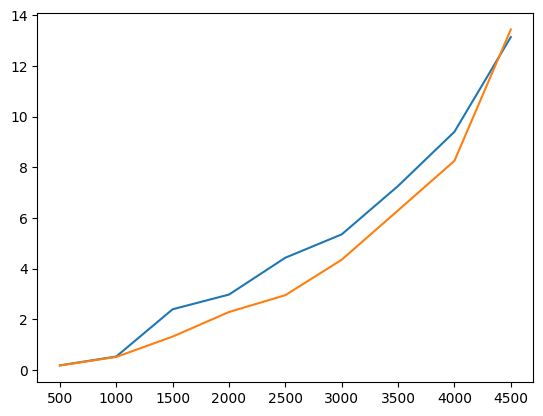

In [41]:
plt.plot(nodes_vec,time_vec)
plt.plot(nodes_vec,time_vec_fib)


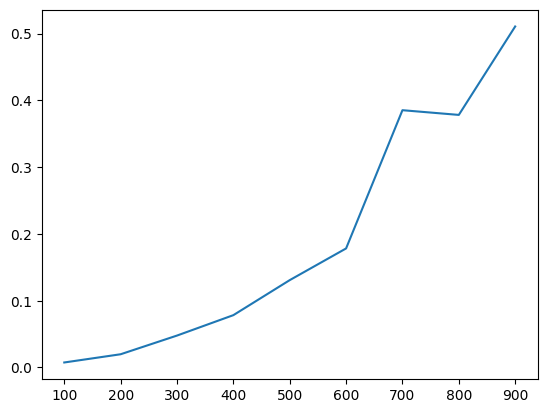

In [36]:
plt.plot(nodes_vec,time_vec_fib)